This is another tutorial post, this time looking at use of the function `AdjustQueryProperties()` to tune substructure queries without having to write SMARTS patterns. I show how to use the functionality both in the RDKit PostgreSQL cartridge and from Python.

This is an updated and expanded version of an [old blog post](https://rdkit.blogspot.com/2016/07/tuning-substructure-queries-ii.html).

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import json

import rdkit
%load_ext sql
print(rdkit.__version__)
import time
print(time.asctime())

2024.09.5
Sat Mar  1 06:53:41 2025


# Adjusting queries in the cartridge

Our starting point is a query against ChEMBL for molecules that contain a pyridine ring.

10 rows affected.


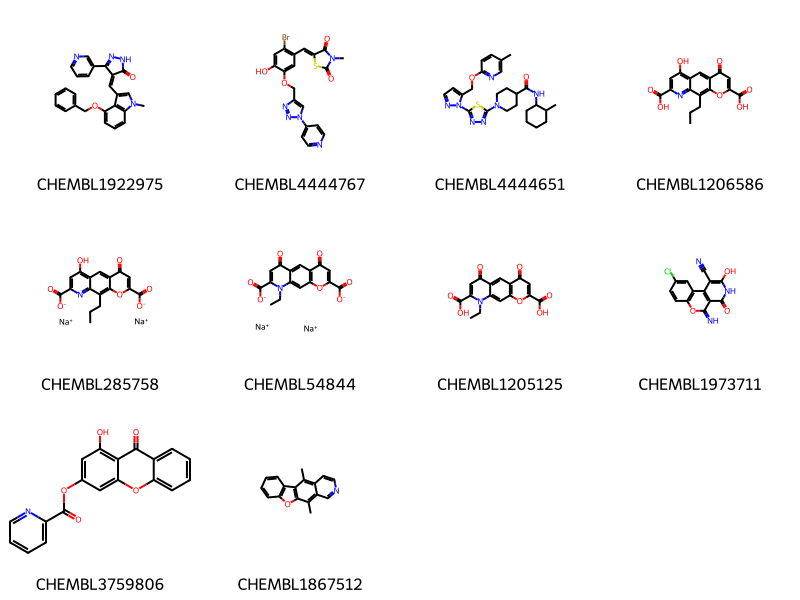

In [2]:
data = %sql postgresql://localhost/chembl_35 \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>'c1ccccn1'::mol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[x for x,y in data],molsPerRow=4)

If we add two dummy atoms to that in order to look for 2-6 di-substituted pyridines we initially get no results:

In [3]:
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>'*c1cccc(*)n1' limit 10 ;

 * postgresql://localhost/chembl_35
0 rows affected.


But we can change that by calling the new `mol_adjust_query_properties()` function:

 * postgresql://localhost/chembl_35
10 rows affected.


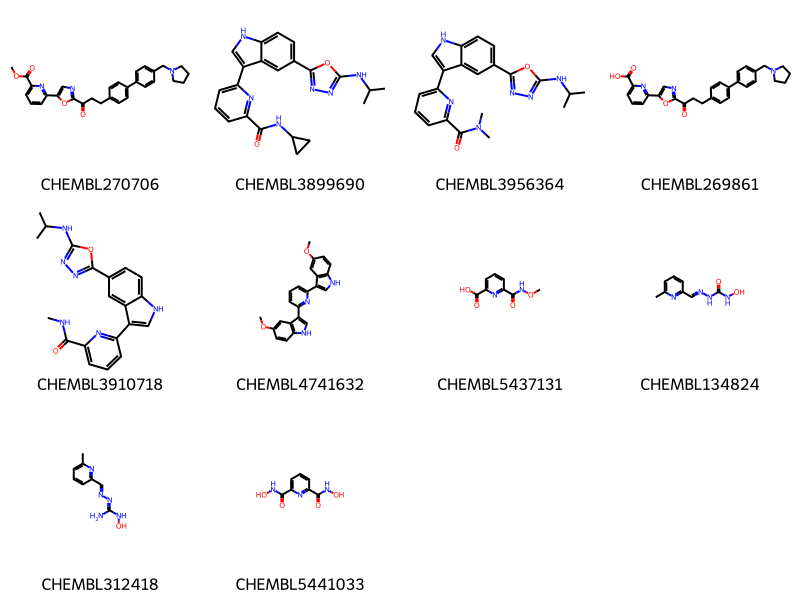

In [4]:
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties('*c1cccc(*)n1'::mol) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[x for x,y in data],molsPerRow=4)

This function makes a number of changes by default:

  - Converts dummy atoms into "any" queries
  - Adds a degree query to every ring atom so that its substitution must match what was provided
  - Aromaticity perception is done (if it hasn't been done already)
  
The addition of degree queries has the consequence that we only find di-substituted pyridines. We can lift that restriction by providing some additional configuration information to `mol_adjust_query_properties()` as JSON:

 * postgresql://localhost/chembl_35
10 rows affected.


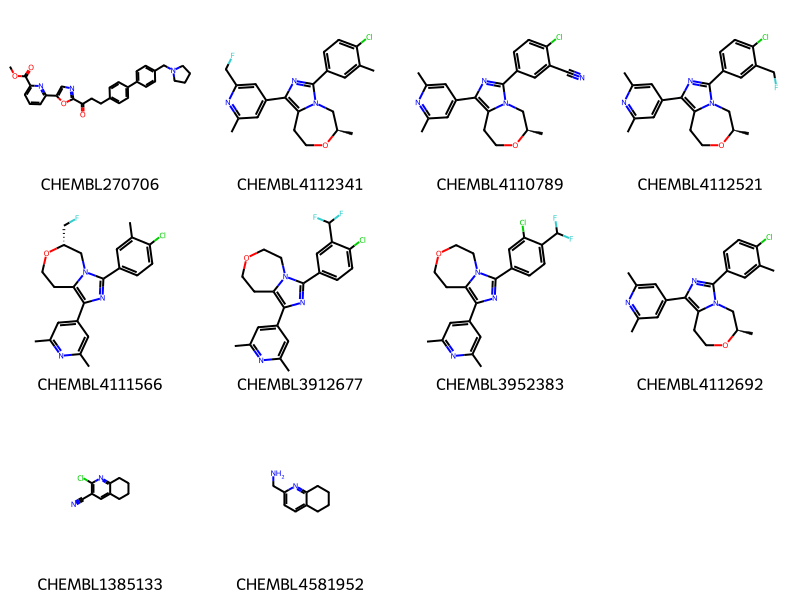

In [5]:
params = {'adjustDegree':False}
params = json.dumps(params)
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties('*c1cccc(*)n1'::mol,\
                                         :params) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[x for x,y in data],molsPerRow=4)

Notice that now we have additional substitutions on the rings. However now there are also some examples where the pyridine is part of a fused ring. We can get rid of these by telling `mol_adjust_query_properties()` to also add a ring-count query to every ring atom :

 * postgresql://localhost/chembl_35
10 rows affected.


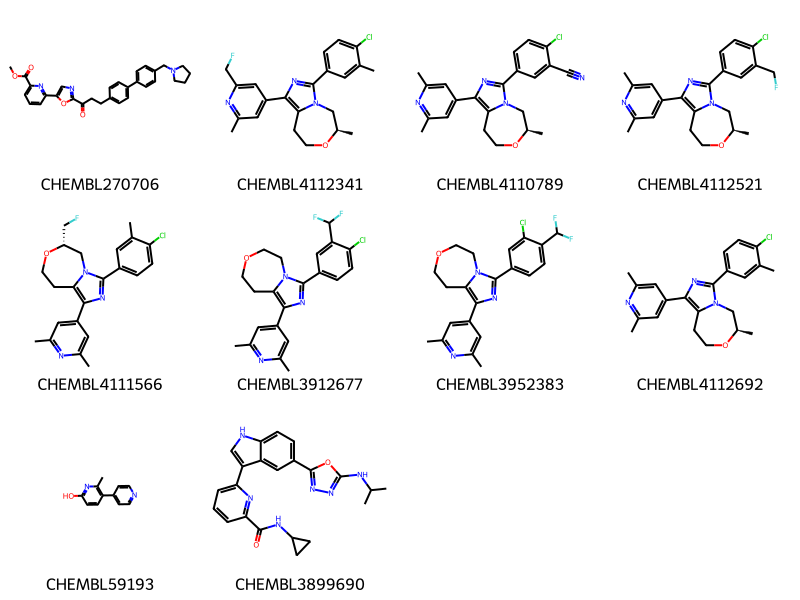

In [6]:
params = {'adjustDegree':False,
         'adjustRingCount':True}
params = json.dumps(params)
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties('*c1cccc(*)n1'::mol,\
                                         :params) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

So now we are getting results which can have more than two substituents on the pyridine ring, but where the pyridine cannot be in a fused ring.

To explore the next set of options, we extend the query a little bit to search for 2-6 substituted pyridines where one of the substituents starts with an `NC=O`:

 * postgresql://localhost/chembl_35
10 rows affected.


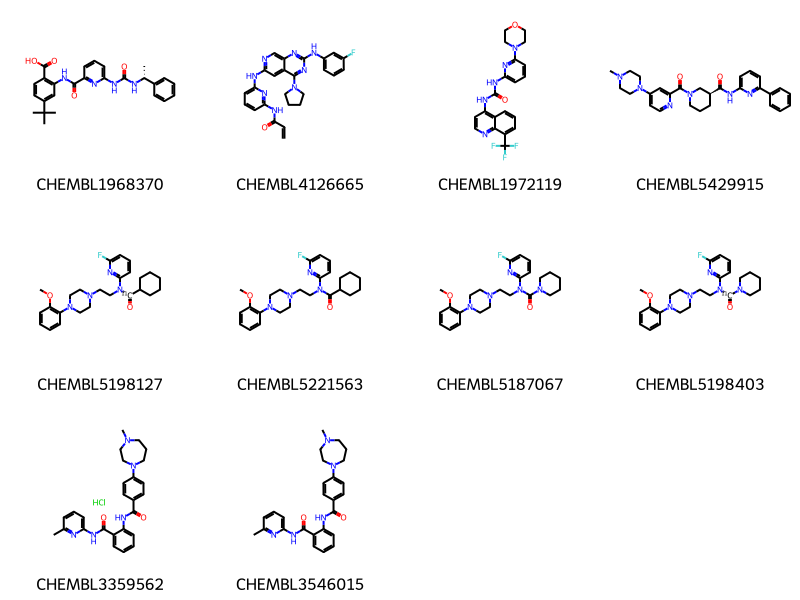

In [7]:
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1'::mol) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

Let's allow the degrees of ring atoms or dummies to change, but not the degree of chain atoms, this should remove matches like those to molecule CHEMBL5221563 above:

 * postgresql://localhost/chembl_35
10 rows affected.


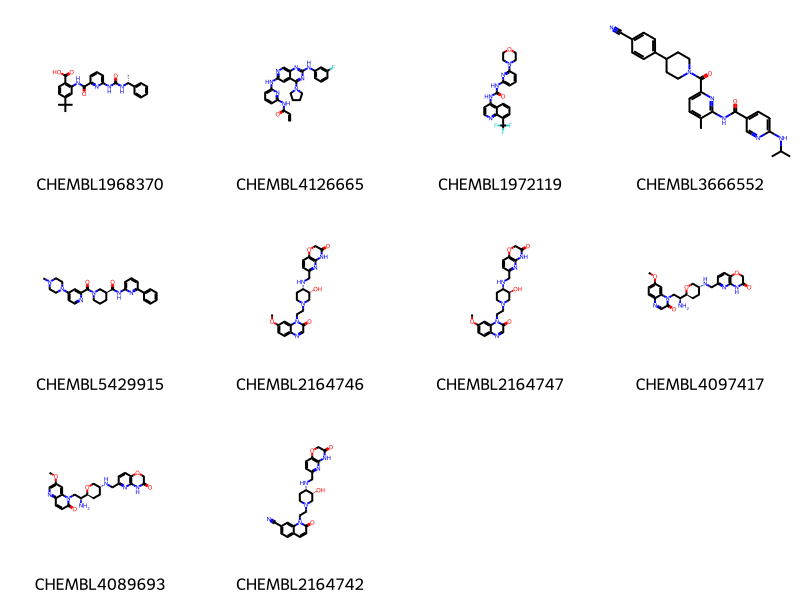

In [8]:
params = {'adjustDegree':True,
         'adjustDegreeFlags':'IGNORERINGS|IGNOREDUMMIES'}
params = json.dumps(params)
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1'::mol,\
                                         :params) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

And now get rid of the fused rings by turning on the ring-count changes too:

 * postgresql://localhost/chembl_35
10 rows affected.


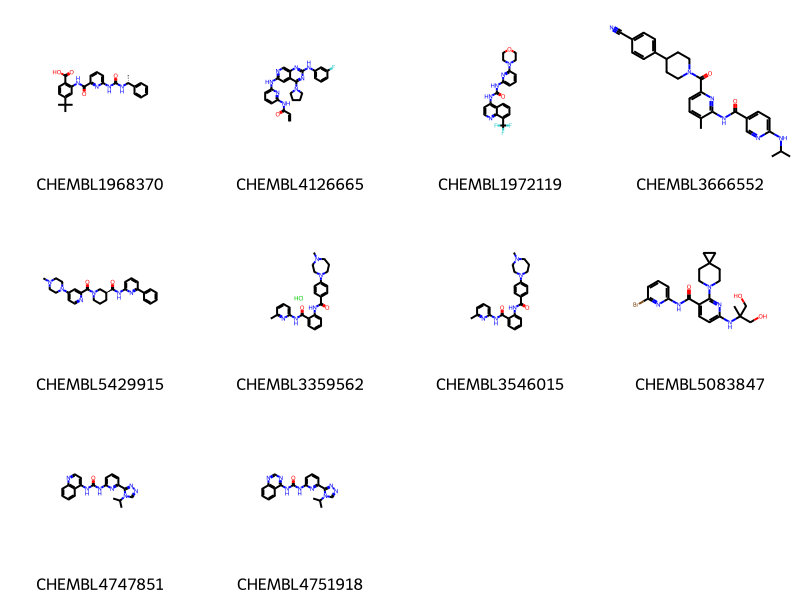

In [9]:
params = {'adjustDegree':True,
         'adjustDegreeFlags':'IGNORERINGS|IGNOREDUMMIES',
         'adjustRingCount':True}
params = json.dumps(params)
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1'::mol,\
                                         :params) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

## Queries from mol blocks

The same adjustments can be used on query molecules constructed from mol blocks:

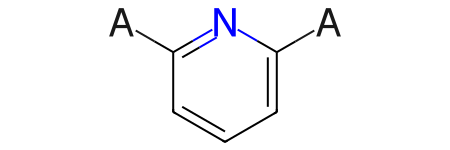

In [10]:
mb="""
  Mrv1561 07261609522D          

  8  8  0  0  0  0            999 V2000
   -1.9866    0.7581    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7011    0.3455    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7011   -0.4795    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.9866   -0.8920    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2721   -0.4795    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2721    0.3455    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.4155    0.7580    0.0000 A   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5577    0.7580    0.0000 A   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  1  6  2  0  0  0  0
  2  3  2  0  0  0  0
  3  4  1  0  0  0  0
  4  5  2  0  0  0  0
  5  6  1  0  0  0  0
  2  7  1  0  0  0  0
  6  8  1  0  0  0  0
M  END
"""
Chem.MolFromMolBlock(mb)

The semantics of mol block queries are a bit different since we already have query atoms:

 * postgresql://localhost/chembl_35
10 rows affected.


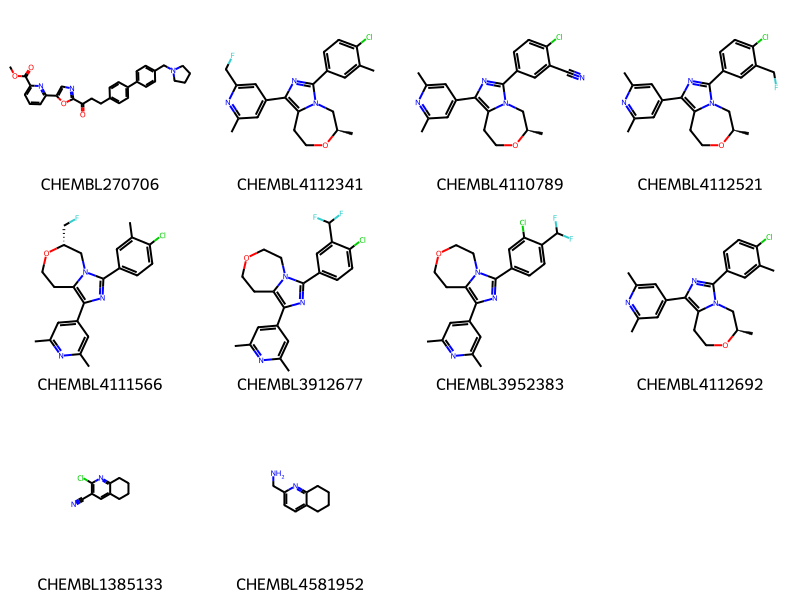

In [11]:
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_from_ctab(:mb) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

Calling `mol_adjust_query_properties()` here effectively just adds the degree queries (since the dummies are already queries), providing the same results as in Block 4 above:

 * postgresql://localhost/chembl_35
10 rows affected.


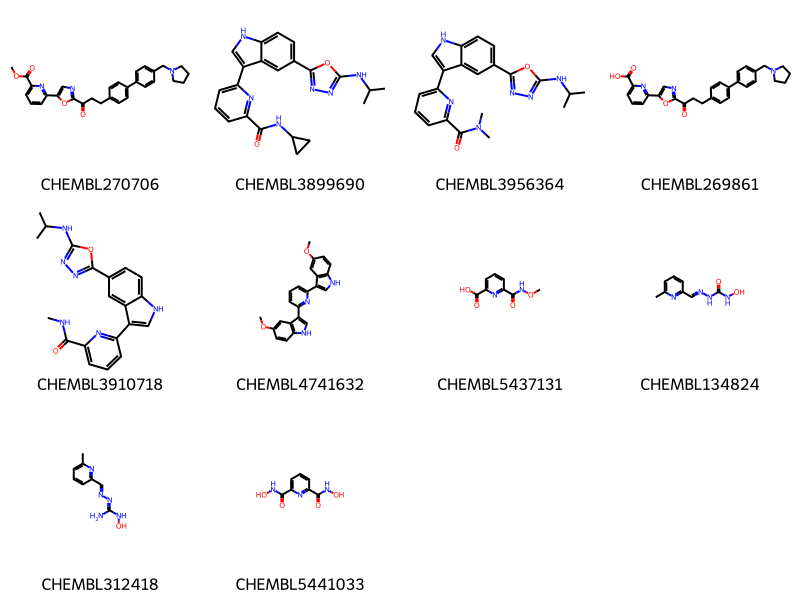

In [12]:
data = %sql \
    select chembl_id,molfile from rdk.mols join compound_structures \
    using (molregno) \
    join chembl_id_lookup on (entity_id=molregno and entity_type='COMPOUND')\
    where m@>mol_adjust_query_properties(mol_from_ctab(:mb)) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

# Using this from Python

The same options are available from Python using the function `Chem.AdjustQueryProperties()`:

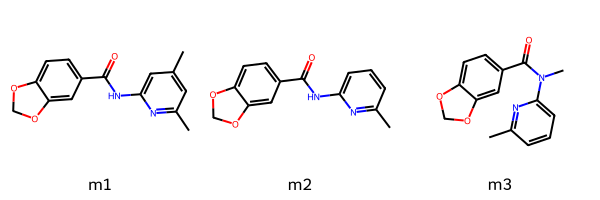

In [13]:
m1 = Chem.MolFromSmiles('Cc1cc(C)nc(NC(=O)c2ccc3c(c2)OCO3)c1')
m2 = Chem.MolFromSmiles('c1cc(C)nc(NC(=O)c2ccc3c(c2)OCO3)c1')
m3 = Chem.MolFromSmiles('c1cc(C)nc(N(C)C(=O)c2ccc3c(c2)OCO3)c1')
Draw.MolsToGridImage((m1,m2,m3),legends=['m1','m2','m3'])

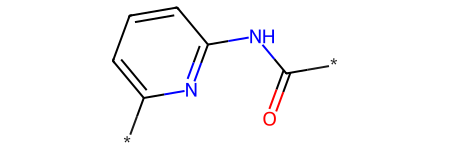

In [14]:
q = Chem.MolFromSmiles('*c1cccc(NC(=O)*)n1')
q

Initially this has no substructure matches since the dummy atoms can't match anything:

In [15]:
m1.HasSubstructMatch(q),m2.HasSubstructMatch(q),m3.HasSubstructMatch(q)

(False, False, False)

The defaults to `Chem.AdjustQueryProperties()` take care of this, but they also exclude the match to m1 due to the degree queries added to ring atoms:

In [16]:
tq = Chem.AdjustQueryProperties(q)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(False, True, True)

Turn off the degree queries and all the molecules match:

In [17]:
params = Chem.AdjustQueryParameters()
params.adjustDegree=False
tq = Chem.AdjustQueryProperties(q,params)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(True, True, True)

We can also use the degree query only on chain atoms, this disables the match of m3:

In [18]:
params = Chem.AdjustQueryParameters()
params.adjustDegree=True
params.adjustDegreeFlags=Chem.ADJUST_IGNORERINGS|Chem.ADJUST_IGNOREDUMMIES
tq = Chem.AdjustQueryProperties(q,params)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(True, True, False)

# Some other adjust query options

These are easier to demonstrate in Python, but all are also available in the PostgreSQL cartridge.

## adjustRingChain

Query atoms in rings/chains only match atoms in rings/chains.

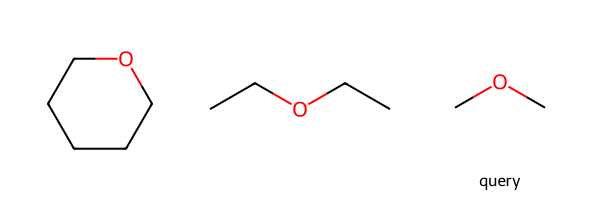

In [19]:
m1 = Chem.MolFromSmiles('C1CCCCO1')
m2 = Chem.MolFromSmiles('CCOCC')
q = Chem.MolFromSmiles('COC')
Draw.MolsToGridImage((m1,m2,q),legends=['','','query'])

In [20]:
print(m1.HasSubstructMatch(q),m2.HasSubstructMatch(q))

True True


In [21]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.adjustRingChain = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq))

False True


## adjustConjugatedFiveRings

This one is there to allow queries, particularly sketched queries, with conjugated 5 rings to match both aromatic and non-aromatic molecules. 

Bonds in conjugated 5 rings are converted to `SINGLE|DOUBLE|AROMATIC`

It's easiest to demonstrate with a mol block query:

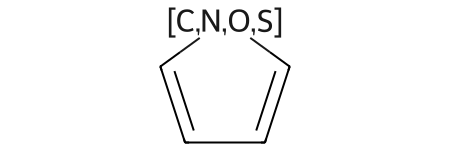

In [22]:
mb = '''atom list query
  Mrv2007 05282011072D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 5 5 0 0 0
M  V30 BEGIN ATOM
M  V30 1 [C,N,O,S] -4.9583 2.185 0 0
M  V30 2 C -6.2042 1.2798 0 0
M  V30 3 C -5.7283 -0.1848 0 0
M  V30 4 C -4.1883 -0.1848 0 0
M  V30 5 C -3.7125 1.2798 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 1 3 4
M  V30 3 1 1 5
M  V30 4 2 2 3
M  V30 5 2 4 5
M  V30 END BOND
M  V30 END CTAB
M  END
'''
q = Chem.MolFromMolBlock(mb)
q

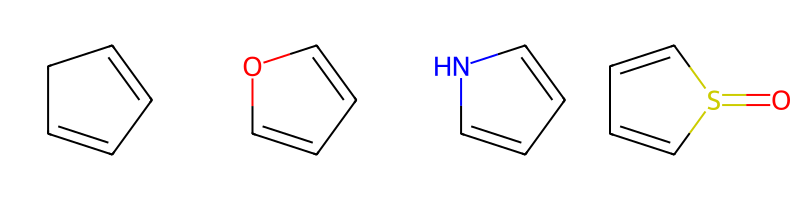

In [23]:
m1 = Chem.MolFromSmiles('C1=CCC=C1')
m2 = Chem.MolFromSmiles('C1=COC=C1')
m3 = Chem.MolFromSmiles('C1=CNC=C1')
m4 = Chem.MolFromSmiles('C1=CS(=O)C=C1')
Draw.MolsToGridImage((m1,m2,m3,m4),molsPerRow=4)

In [24]:
print(m1.HasSubstructMatch(q),m2.HasSubstructMatch(q),m3.HasSubstructMatch(q),m4.HasSubstructMatch(q))

True False False True


In [25]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.adjustConjugatedFiveRings = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq),m4.HasSubstructMatch(tq))

True True True True


Note that this can make make the query more generic than expected:

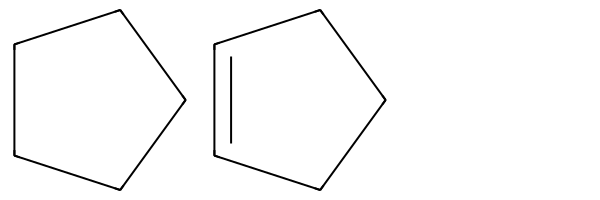

In [26]:
m5 = Chem.MolFromSmiles('C1CCCC1')
m6 = Chem.MolFromSmiles('C1CC=CC1')
Draw.MolsToGridImage((m5,m6))

In [27]:
print(m5.HasSubstructMatch(q),m6.HasSubstructMatch(q))
print(m5.HasSubstructMatch(tq),m6.HasSubstructMatch(tq))


False False
True True


## makeAtomsGeneric/makeBondsGeneric

These two options convert the affected query atoms/bonds to match any atom/bond.

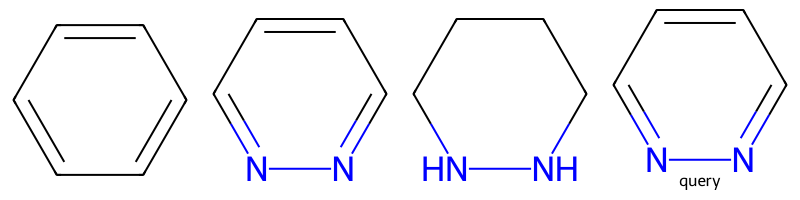

In [28]:
m1 = Chem.MolFromSmiles('c1ccccc1')
m2 = Chem.MolFromSmiles('c1nnccc1')
m3 = Chem.MolFromSmiles('C1NNCCC1')
q = Chem.MolFromSmiles('c1nnccc1')
Draw.MolsToGridImage((m1,m2,m3,q),legends=['','','','query'],molsPerRow=4)

In [29]:
print(m1.HasSubstructMatch(q),m2.HasSubstructMatch(q),m3.HasSubstructMatch(q))

False True False


In [30]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.makeAtomsGeneric = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq))

True True False


In [31]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.makeBondsGeneric = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq))

False True True


In [32]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.makeBondsGeneric = True
params.makeAtomsGeneric = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq))

True True True


## adjustSingleBondsToDegreeOneNeighbors

Converts single bonds from aromatic or conjugated atoms and neighboring atoms with degree one to be `SINGLE | AROMATIC` 


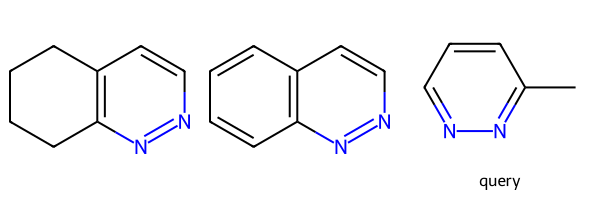

In [33]:
m1 = Chem.MolFromSmiles('C1CCCc2c1nncc2')
m2 = Chem.MolFromSmiles('c1cccc2c1nncc2')
q = Chem.MolFromSmiles('Cc1nnccc1')
Draw.MolsToGridImage((m1,m2,q),legends=['','','query'])

In [34]:
print(m1.HasSubstructMatch(q),m2.HasSubstructMatch(q))

True False


In [35]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.adjustSingleBondsToDegreeOneNeighbors = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq))

True True


## adjustSingleBondsBetweenAromaticAtoms

Converts single bonds between aromatic or conjugated atoms to `SINGLE | AROMATIC` 



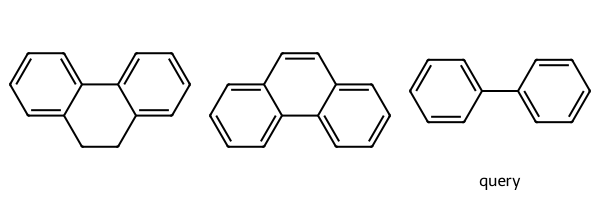

In [36]:
m1 = Chem.MolFromSmiles('C1CC2=CC=CC=C2C2=CC=CC=C12')
m2 = Chem.MolFromSmiles('C1=CC=C2C(C=CC3=CC=CC=C23)=C1')
q = Chem.MolFromSmiles('c1ccccc1c2ccccc2')
Draw.MolsToGridImage((m1,m2,q),legends=['','','query'])

In [37]:
print(m1.HasSubstructMatch(q),m2.HasSubstructMatch(q))

True False


In [38]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.adjustSingleBondsBetweenAromaticAtoms = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq))

True True


## useStereoCareForBonds

This one provides a fine grain control over how double bond stereo in the query is matched.

In [39]:
IPythonConsole.drawOptions.addStereoAnnotation = True

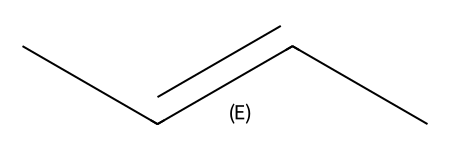

In [40]:
mb = '''
  Mrv2401 03012506222D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 4 3 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -10.037 2.8148 0 0
M  V30 2 C -8.7034 3.5848 0 0
M  V30 3 C -11.3707 3.5848 0 0
M  V30 4 C -7.3697 2.8148 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 2 1 2
M  V30 2 1 1 3
M  V30 3 1 2 4
M  V30 END BOND
M  V30 END CTAB
M  END
'''
q = Chem.MolFromMolBlock(mb)
q

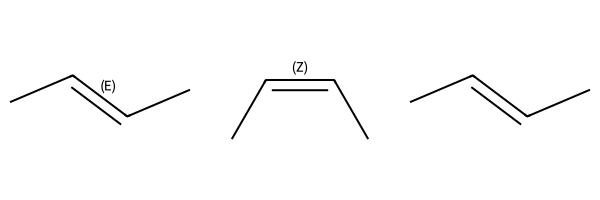

In [41]:
m1 = Chem.MolFromSmiles('C/C=C/C')
m2 = Chem.MolFromSmiles(r'C/C=C\C')
m3 = Chem.MolFromSmiles('CC=CC')
Draw.MolsToGridImage((m1,m2,m3))

In [42]:
ssopts = Chem.SubstructMatchParameters()
ssopts.useChirality = True
print(m1.HasSubstructMatch(q,ssopts),m2.HasSubstructMatch(q,ssopts),m3.HasSubstructMatch(q,ssopts))

True False False


In [43]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.useStereoCareForBonds = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq,ssopts),m2.HasSubstructMatch(tq,ssopts),m3.HasSubstructMatch(tq,ssopts))

True True True


This isn't particularly interesting for this simple case, but it can become relevant for more complex queries

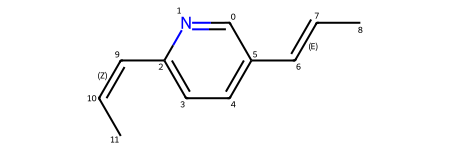

In [44]:
mb = '''
  Mrv2401 03012506432D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 12 12 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -6.2311 2.2894 0 0
M  V30 2 N -7.7711 2.2893 0 0
M  V30 3 C -8.5412 0.9556 0 0
M  V30 4 C -7.7712 -0.378 0 0
M  V30 5 C -6.2312 -0.378 0 0
M  V30 6 C -5.4612 0.9557 0 0
M  V30 7 C -3.9212 0.9557 0 0
M  V30 8 C -3.1512 2.2893 0 0
M  V30 9 C -1.6112 2.2893 0 0
M  V30 10 C -10.0812 0.9557 0 0 STBOX=1
M  V30 11 C -10.8512 -0.378 0 0 STBOX=1
M  V30 12 C -10.0812 -1.7117 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 6 7
M  V30 8 1 8 9
M  V30 9 1 3 10
M  V30 10 1 11 12
M  V30 11 2 7 8
M  V30 12 2 10 11 STBOX=1
M  V30 END BOND
M  V30 END CTAB
M  END
'''
IPythonConsole.drawOptions.addAtomIndices = True
q = Chem.MolFromMolBlock(mb)
q

The RDKit renderer doesn't currently display it (memo to self: that's a feature we should add), but the double bond between atoms 9 and 10 has the stereo care flag set:

In [45]:
q.GetBondBetweenAtoms(9,10).HasProp('molStereoCare')

1

In [46]:
IPythonConsole.drawOptions.addAtomIndices = False

Two molecules:

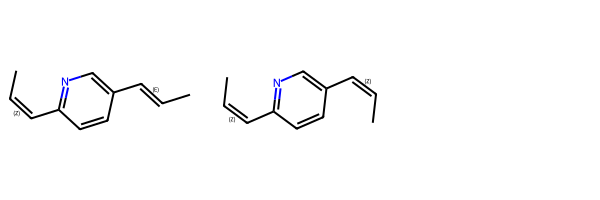

In [47]:
m1 = Chem.MolFromSmiles(r'C/C=C\c1ncc(cc1)/C=C/C')
m2 = Chem.MolFromSmiles(r'C/C=C\c1ncc(cc1)/C=C\C')
Draw.MolsToGridImage((m1,m2))

The default behavior is to only match the first molecule, because our query has one cis and one trans but the second molecule has two cis bonds.

In [48]:
ssopts = Chem.SubstructMatchParameters()
ssopts.useChirality = True
print(m1.HasSubstructMatch(q,ssopts),m2.HasSubstructMatch(q,ssopts))

True False


If we set `useStereoCareForBonds` the stereochemistry on the trans bond in the query (the one that does not have the `molStereoCare` flag set) is ignored when querying.

In [49]:
params = Chem.AdjustQueryParameters.NoAdjustments()
params.useStereoCareForBonds = True
tq = Chem.AdjustQueryProperties(q,params)
print(m1.HasSubstructMatch(tq,ssopts),m2.HasSubstructMatch(tq,ssopts))

True True


We could, of course, have accomplished the same thing by explicitly marking the second query bond as stereo unknown:

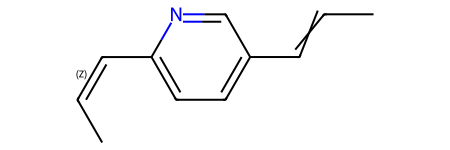

In [50]:
mb = '''
  Mrv2401 03012506492D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 12 12 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -6.2311 2.2894 0 0
M  V30 2 N -7.7711 2.2893 0 0
M  V30 3 C -8.5412 0.9556 0 0
M  V30 4 C -7.7712 -0.378 0 0
M  V30 5 C -6.2312 -0.378 0 0
M  V30 6 C -5.4612 0.9557 0 0
M  V30 7 C -3.9212 0.9557 0 0
M  V30 8 C -3.1512 2.2893 0 0
M  V30 9 C -1.6112 2.2893 0 0
M  V30 10 C -10.0812 0.9557 0 0
M  V30 11 C -10.8512 -0.378 0 0
M  V30 12 C -10.0812 -1.7117 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 6 7
M  V30 8 1 8 9
M  V30 9 1 3 10
M  V30 10 1 11 12
M  V30 11 2 7 8 CFG=2
M  V30 12 2 10 11
M  V30 END BOND
M  V30 END CTAB
M  END
'''
q = Chem.MolFromMolBlock(mb)
q

In [51]:
ssopts = Chem.SubstructMatchParameters()
ssopts.useChirality = True
print(m1.HasSubstructMatch(q,ssopts),m2.HasSubstructMatch(q,ssopts))

True True


But sometimes it's easier to just mark the double bonds you care about rather than marking the ones you don't care about.